In [0]:
!pip3 uninstall -y kaggle
!pip3 install --upgrade pip
!pip3 install kaggle==1.5.6
!kaggle -v

!mkdir /root/.kaggle
## Upload the kaggle.json file.
!cp kaggle.json /root/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json

In [0]:
!kaggle competitions download -c plant-seedlings-classification
!unzip plant-seedlings-classification.zip
!rm plant-seedlings-classification.zip sample_submission.csv

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

import os
import cv2
import math
import itertools


from glob import glob
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix


%tensorflow_version 1.x
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, model_from_json
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout, Activation, Flatten, BatchNormalization, LeakyReLU
from tensorflow.keras.optimizers import RMSprop, Adadelta, SGD, Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers.schedules import ExponentialDecay

# Constants

In [0]:
TRAIN_DIRECTORY = "train"
TEST_DIRECTORY = "test"
IMG_HEIGHT = 70
IMG_WIDTH = 70
CATEGORIES = os.listdir(TRAIN_DIRECTORY)
num_classes = len(CATEGORIES)

lwr_hsv = (25,40,50)
upr_hsv = (75,255,255)



# Data Loading

In [8]:
path_to_all_files = TRAIN_DIRECTORY + '/*/*.png' 
files = glob(path_to_all_files)

trainImg = []
trainLabel = []
num = len(files)

# Obtain images and resizing, obtain labels
for imag in files:
    
    img = cv2.imread(imag)

    blurr = cv2.GaussianBlur(img,(5,5),0)
    hsv = cv2.cvtColor(blurr,cv2.COLOR_BGR2HSV)
    mask = cv2.inRange(hsv,lwr_hsv,upr_hsv)
    struc = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(11,11))
    mask = cv2.morphologyEx(mask,cv2.MORPH_CLOSE,struc)
    boolean = mask>0
    new_img = np.zeros_like(img,np.uint8)
    new_img[boolean] = img[boolean]
    res_img = new_img


    rez_img = cv2.resize(res_img, dsize =(IMG_WIDTH, IMG_HEIGHT),interpolation = cv2.INTER_AREA)
    rez_img = rez_img.reshape(IMG_WIDTH, IMG_HEIGHT, 3)
    trainImg.append(rez_img)
    
    trainLabel.append(imag.split('/')[-2])  # Get image label (folder name)

trainImg = np.asarray(trainImg)  # Train images set
trainLabel = pd.DataFrame(trainLabel)  # Train labels set

print(trainImg.shape)
print(trainLabel.shape)

(4750, 70, 70, 3)
(4750, 1)


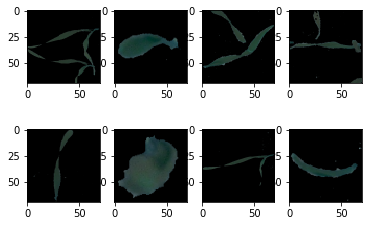

In [6]:
for i in range(8):
    plt.subplot(2, 4, i + 1)
    plt.imshow(trainImg[i*20])

# Cleaning data

## Normalize Input & Categorize Labels

In [0]:
trainImg = trainImg / 255

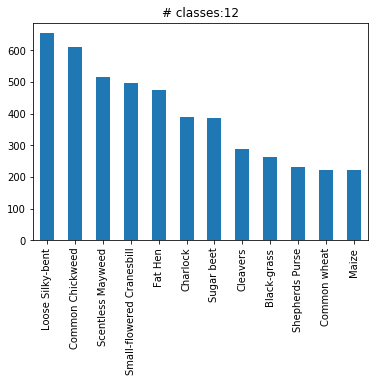

In [11]:
le = preprocessing.LabelEncoder()
encodeTrainLabels = le.fit_transform(trainLabel[0])
clearTrainLabel = to_categorical(encodeTrainLabels)

# Plot of label types numbers
trainLabel[0].value_counts().plot(kind='bar', title="# classes:" + str(clearTrainLabel.shape[1]))


# Model Definition

## Data splitting and Generator

In [0]:
X_train, X_valid, y_train, y_valid = train_test_split(trainImg, clearTrainLabel, 
                                                test_size=0.2, random_state=33, 
                                                stratify = clearTrainLabel)

In [0]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=180,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.3, # Randomly zoom image
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True, # randomly flip images
        )

datagen.fit(X_train)

## Model Architecture

In [11]:
model = Sequential()

model.add(Conv2D(filters=64, kernel_size=(5, 5), padding='same', input_shape=(IMG_WIDTH, IMG_WIDTH, 3)))
model.add(BatchNormalization(axis=3))
model.add(LeakyReLU(0.1))

model.add(Conv2D(filters=64,kernel_size=(5, 5), padding='same'))
model.add(BatchNormalization(axis=3))
model.add(LeakyReLU(0.1))

model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2)))

model.add(Conv2D(filters=128, kernel_size=(5, 5), padding='same'))
model.add(BatchNormalization(axis=3))
model.add(LeakyReLU(0.1))

model.add(Conv2D(filters=128, kernel_size=(5, 5), padding='same'))
model.add(BatchNormalization(axis=3))
model.add(LeakyReLU(0.1))

model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2)))

model.add(Conv2D(filters=256, kernel_size=(5, 5), padding='same'))
model.add(BatchNormalization(axis=3))
model.add(LeakyReLU(0.1))

model.add(Conv2D(filters=256, kernel_size=(5, 5), padding='same'))
model.add(BatchNormalization(axis=3))
model.add(LeakyReLU(0.1))

model.add(Conv2D(filters=256, kernel_size=(5, 5), padding='same'))
model.add(BatchNormalization(axis=3))
model.add(LeakyReLU(0.1))

model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2)))

model.add(Conv2D(filters=256, kernel_size=(5, 5), padding='same'))
model.add(BatchNormalization(axis=3))
model.add(LeakyReLU(0.1))

model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2)))

model.add(Flatten())

model.add(Dropout(0.3))
model.add(Dense(128))
model.add(BatchNormalization(axis=-1))
model.add(Activation('relu'))


model.add(Dropout(0.3))
model.add(Dense(num_classes))
model.add(BatchNormalization(axis=-1))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 70, 70, 64)        4864      
_________________________________________________________________
batch_normalization (BatchNo (None, 70, 70, 64)        256       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 70, 70, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 70, 70, 64)        102464    
_________________________________________________________________
batch_normalization_1 (Batch (None, 70, 70, 64)        256       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 70, 70, 64)        0         
_________________________________________

In [0]:
# learning rate reduction
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.4, 
                                            min_lr=0.00001)

# checkpoints
filepath="weight-cnn-filter.best_{epoch:02d}-{val_acc:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', 
                             verbose=1, save_best_only=True, mode='max')
filepath="weights-cnn-filter.last_auto4.hdf5"
checkpoint_all = ModelCheckpoint(filepath, monitor='val_acc', 
                                 verbose=1, save_best_only=False, mode='max')

BATCH_SIZE = 16

In [13]:
# fit model
hist = model.fit_generator(datagen.flow(X_train, y_train, batch_size=BATCH_SIZE),
                           epochs=30,
                           validation_data=(X_valid, y_valid), 
                           steps_per_epoch=(10*X_train.shape[0]) / BATCH_SIZE,
                           callbacks=[checkpoint, learning_rate_reduction, checkpoint_all])


Epoch 1/30
 950/2375 [===========>..................] - ETA: 1s - loss: 1.0372 - acc: 0.6611
Epoch 00001: val_acc improved from -inf to 0.66105, saving model to weight-cnn-filter.best_01-0.66.hdf5

Epoch 00001: saving model to weights-cnn-filter.last_auto4.hdf5
2375/2375 [==============================] - 104s 44ms/step - loss: 1.3015 - acc: 0.5775 - val_loss: 1.0390 - val_acc: 0.6611
Epoch 2/30
 944/2375 [==========>...................] - ETA: 1s - loss: 0.5349 - acc: 0.8093
Epoch 00002: val_acc improved from 0.66105 to 0.80842, saving model to weight-cnn-filter.best_02-0.81.hdf5

Epoch 00002: saving model to weights-cnn-filter.last_auto4.hdf5
2375/2375 [==============================] - 97s 41ms/step - loss: 0.7820 - acc: 0.7508 - val_loss: 0.5386 - val_acc: 0.8084
Epoch 3/30
 928/2375 [==========>...................] - ETA: 1s - loss: 0.4771 - acc: 0.8427
Epoch 00003: val_acc improved from 0.80842 to 0.83684, saving model to weight-cnn-filter.best_03-0.84.hdf5

Epoch 00003: saving m

In [0]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='CNN_filter_model_arch.png', dpi=200, show_shapes=True, show_layer_names=True)

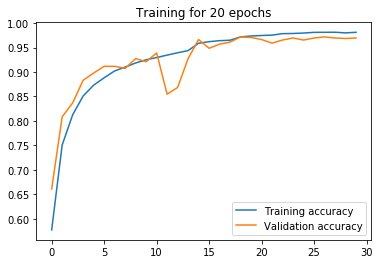

In [14]:
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('Training for ' +str(30)+ ' epochs')
plt.legend(['Training accuracy', 'Validation accuracy'], loc='lower right')
plt.savefig('history_accuracy.png', dpi=200)
plt.show()

In [0]:
import pickle
with open('CNN_filter_history.pkl', 'wb') as file_pi:
    pickle.dump(hist.history, file_pi)
    
model_json = model.to_json()
with open("CNN_filter_model.json", "w") as json_file:
    json_file.write(model_json)

In [16]:
model.load_weights("weight-cnn-filter.best_19-0.97.hdf5")

print("Train accuracy", model.evaluate(X_train, y_train))  # Evaluate on train set
print("Validation accuracy", model.evaluate(X_valid, y_valid))  # Evaluate on test set

3800/3800 [==============================] - 2s 597us/sample - loss: 0.0307 - acc: 0.9903
Train accuracy [0.030691544165785768, 0.99026316]
950/950 [==============================] - 1s 649us/sample - loss: 0.1006 - acc: 0.9716
Validation accuracy [0.10055519155765835, 0.97157896]


In [4]:
# load json and create model
json_file = open('CNN_no_filter_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [0]:
from tensorflow.keras.utils import plot_model
plot_model(loaded_model, to_file='CNN_filter_model_arch.png', dpi=200, show_layer_names=False, show_shapes=True)

# Confusion Matrix

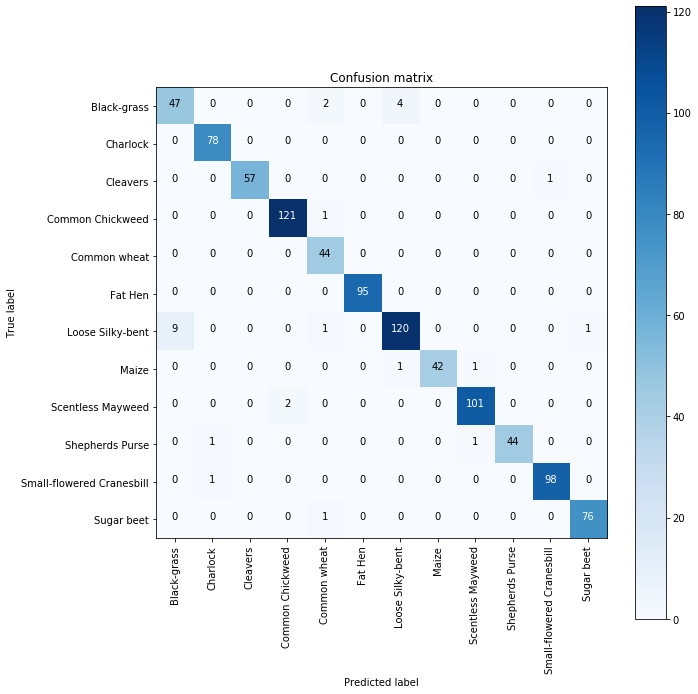

In [17]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix',cmap=plt.cm.Blues):
    fig = plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig('confusion_matrix.png', dpi=200)

# Predict the values from the validation dataset
y_pred = model.predict(X_valid)
y_pred_classes = np.argmax(y_pred, axis = 1) 
y_true = np.argmax(y_valid, axis = 1) 

# confusion matrix
confusionMTX = confusion_matrix(y_true, y_pred_classes) 

# plot the confusion matrix
plot_confusion_matrix(confusionMTX, classes = le.classes_) 


# Predicting on Test Set

In [18]:
path =  TEST_DIRECTORY + '/*.png'
files = glob(path)

testImg = []
testId = []
num = len(files)

# Obtain images and resizing, obtain labels
for imag in files:
    testId.append(imag.split('/')[-1])  # Images id's
    
    img = cv2.imread(imag)

    blurr = cv2.GaussianBlur(img,(5,5),0)
    hsv = cv2.cvtColor(blurr,cv2.COLOR_BGR2HSV)
    mask = cv2.inRange(hsv,lwr_hsv,upr_hsv)
    struc = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(11,11))
    mask = cv2.morphologyEx(mask,cv2.MORPH_CLOSE,struc)
    boolean = mask>0
    new_img = np.zeros_like(img,np.uint8)
    new_img[boolean] = img[boolean]
    res_img = new_img


    rez_img = cv2.resize(res_img, dsize =(IMG_WIDTH, IMG_HEIGHT),interpolation = cv2.INTER_AREA)
    rez_img = rez_img.reshape(IMG_WIDTH, IMG_HEIGHT, 3)
    testImg.append(rez_img)
    
    
    
    

testImg = np.asarray(testImg)  # Train images set

print(testImg.shape)

(794, 70, 70, 3)


In [0]:
testImg = testImg / 255


In [0]:
pred = model.predict(testImg)

In [0]:
# Write result to file
predNum = np.argmax(pred, axis=1)
predStr = le.classes_[predNum]

res = {'file': testId, 'species': predStr}
res = pd.DataFrame(res)
res.to_csv("res.csv", index=False)

# Test Score: 0.97103

# Extracting Last Layer Features

In [0]:
model_feat = Model(inputs=model.input,outputs=model.get_layer('dense').output)

feat_train = model_feat.predict(X_train)
print(feat_train.shape)

feat_val = model_feat.predict(X_valid)
print(feat_val.shape)

feat_test = model_feat.predict(testImg)
print(feat_test.shape)

In [0]:
np.save("X_train", feat_train)
np.save("X_valid", feat_val)
np.save("X_test", feat_test)

np.save("y_train", y_train)
np.save("y_valid", y_valid)

# Some further analysis

In [32]:
mis_class = []

# Predict the values from the validation dataset
y_pred = model.predict(X_valid)
y_pred_classes = np.argmax(y_pred, axis = 1) 
y_true = np.argmax(y_valid, axis = 1) 

for i in range(len(y_pred)):
    if(not y_pred_classes[i] == y_true[i]):
        print("Predicted:", y_pred_classes[i], "| True:", y_true[i], "| Index:", i)


Predicted: 4 | True: 0 | Index: 22
Predicted: 0 | True: 6 | Index: 60
Predicted: 0 | True: 6 | Index: 74
Predicted: 11 | True: 6 | Index: 122
Predicted: 6 | True: 7 | Index: 171
Predicted: 3 | True: 8 | Index: 210
Predicted: 3 | True: 8 | Index: 224
Predicted: 0 | True: 6 | Index: 249
Predicted: 10 | True: 2 | Index: 322
Predicted: 0 | True: 6 | Index: 357
Predicted: 4 | True: 11 | Index: 375
Predicted: 6 | True: 0 | Index: 408
Predicted: 0 | True: 6 | Index: 434
Predicted: 4 | True: 6 | Index: 443
Predicted: 0 | True: 6 | Index: 576
Predicted: 0 | True: 6 | Index: 602
Predicted: 0 | True: 6 | Index: 627
Predicted: 6 | True: 0 | Index: 675
Predicted: 4 | True: 3 | Index: 711
Predicted: 1 | True: 9 | Index: 753
Predicted: 1 | True: 10 | Index: 772
Predicted: 4 | True: 0 | Index: 827
Predicted: 6 | True: 0 | Index: 829
Predicted: 0 | True: 6 | Index: 839
Predicted: 8 | True: 7 | Index: 847
Predicted: 8 | True: 9 | Index: 929
Predicted: 6 | True: 0 | Index: 936


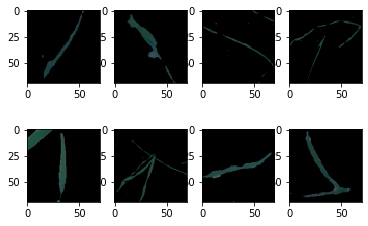

In [13]:
difficults = [60, 74, 576, 602, 627, 675, 936, 839]

for i in range(8):
    plt.subplot(2, 4, i + 1)
    plt.imshow(X_valid[difficults[i]])